In [31]:

# =============================================================================
# CELL 1: SETUP AND CONFIGURATION (UPDATED)
# =============================================================================
# This is the main control panel for the experiment. Set the session path, 
# define which data and algorithms to process, and select the severity 
# threshold for anomaly removal.

import pandas as pd
import numpy as np
import os
import glob
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. PATH CONFIGURATION ---
# The script assumes it is located in your project's root directory 
# (e.g., /TimeSeries/). All paths are relative to that location.

# Path to the specific session folder containing the anomaly detection results.
SESSION_PATH = './Anomaly_results/session_02_ul_outbound/' 

# The prefix of the data files you want to process (e.g., 'ul_outbound')
DATA_PREFIX = 'ul_outbound'

# --- 2. ALGORITHM SELECTION ---
# All available algorithms from the anomaly detection run
AVAILABLE_ALGORITHMS = [
    'aer', 
    'tadgan', 
    'lstm_dynamic_threshold', 
    'lstm_autoencoder', 
    'dense_autoencoder', 
    'vae'
]

# >>> CHANGE THIS LINE to run all algorithms <<<
ALGORITHMS_TO_PROCESS = [
    'aer',
    'tadgan',
    'lstm_dynamic_threshold',
    'lstm_autoencoder',
    'dense_autoencoder',
    'vae'
]


# --- 3. SEVERITY THRESHOLD CONFIGURATION ---
THRESHOLDS = {
    # Removes only the most severe anomalies. A safe starting point.
    "conservative": 0.8,
    # A balanced approach, based on the average severity of several models.
    "moderate": 0.5,
    # Removes a much larger number of detected anomalies.
    "aggressive": 0.2
}

# Choose which threshold to apply in this run: "conservative", "moderate", or "aggressive"
SELECTED_THRESHOLD_NAME = "aggressive"
SELECTED_THRESHOLD_VALUE = THRESHOLDS[SELECTED_THRESHOLD_NAME]

# --- 4. DATA AND OUTPUT PATHS (UPDATED LOGIC) ---
# Paths to the original raw datasets for baseline calculation
file_ul_outbound_november = './datasets/D4_01-30_11_2024/KPI_UL_Outbound_01-30_11_2024 - Part 4.csv'
file_ul_outbound_december = './datasets/D5_01-12-2024_02-01-2025/KPI_UL_Outbound_011224_020125 - Part4.csv'
file_ul_outbound_january = './datasets/D6_03-01-2025_02-02-2025/KPI_UL_Outbound_030125_020225 - Part4.csv'

# Root directory for saving all outputs from this experiment
POST_ANOMALY_OUTPUT_DIR = './Post_anomaly_dataset/'
# Create a new, unique, timestamped folder for this specific run's results
RUN_TIMESTAMP = datetime.now().strftime('%Y%m%d_%H%M%S')
SESSION_OUTPUT_DIR = os.path.join(POST_ANOMALY_OUTPUT_DIR, f"run_{RUN_TIMESTAMP}_{SELECTED_THRESHOLD_NAME}")
os.makedirs(SESSION_OUTPUT_DIR, exist_ok=True)


print(f"Configuration loaded for '{DATA_PREFIX}' data.")
print(f"Available algorithms: {AVAILABLE_ALGORITHMS}")
print(f"Processing with results from: {ALGORITHMS_TO_PROCESS}")
print(f"Using '{SELECTED_THRESHOLD_NAME}' threshold of: {SELECTED_THRESHOLD_VALUE}")
print(f"All outputs for this run will be saved in: {SESSION_OUTPUT_DIR}")

Configuration loaded for 'ul_outbound' data.
Available algorithms: ['aer', 'tadgan', 'lstm_dynamic_threshold', 'lstm_autoencoder', 'dense_autoencoder', 'vae']
Processing with results from: ['aer', 'tadgan', 'lstm_dynamic_threshold', 'lstm_autoencoder', 'dense_autoencoder', 'vae']
Using 'aggressive' threshold of: 0.2
All outputs for this run will be saved in: ./Post_anomaly_dataset/run_20250825_134925_aggressive


In [ ]:
# =============================================================================
# CELL 2: ESTABLISH BASELINE SCORE (CORRECTED)
# =============================================================================
# This cell loads the **original, uncleaned** `ul_outbound` data, prepares it, 
# filters out time series that are too short for evaluation, and then trains 
# the `bolt_base` model to get our starting MASE score.

print("\n--- Loading and Processing Original Data for Baseline ---")
columns_ul_out = ['CC', 'NDC', 'Attempts', 'Failures', '# Distinct Users', 'Operator Code', 'Day', 'Month', 'Year', 'Time Slot', 'Sample ID']

# Load and combine the original datasets
df_ul_outbound_november = pd.read_csv(file_ul_outbound_november, usecols=columns_ul_out)
df_ul_outbound_december = pd.read_csv(file_ul_outbound_december, usecols=columns_ul_out)
df_ul_outbound_january = pd.read_csv(file_ul_outbound_january, usecols=columns_ul_out)
original_df = pd.concat([df_ul_outbound_november, df_ul_outbound_december, df_ul_outbound_january], ignore_index=True)

# Replicate the feature engineering from the first notebook
original_df['Date'] = pd.to_datetime(original_df['Year'].astype(str) + '-' + original_df['Month'].astype(str) + '-' + original_df['Day'].astype(str))
original_df['Hour'] = original_df['Time Slot'].astype(str) + ':' + ((original_df['Sample ID'].astype(int) - 1) * 15).astype(str) + ':00'
original_df['timestamp'] = pd.to_datetime(original_df['Date'].dt.strftime('%Y-%m-%d') + ' ' + original_df['Hour'])
original_df['Failure/Attempt Percentage'] = (original_df['Failures'] / original_df['Attempts']) * 100

# Group and format for AutoGluon
grouped_df = original_df.groupby(['Operator Code', 'timestamp']).sum(numeric_only=True).reset_index()
ts_df_original = TimeSeriesDataFrame.from_data_frame(
    grouped_df[['Operator Code', 'timestamp', 'Failure/Attempt Percentage']], 
    id_column='Operator Code', 
    timestamp_column='timestamp'
)
ts_df_original = ts_df_original.fill_missing_values()

# --- FIX: Filter out time series that are too short for evaluation ---
prediction_length = 96
item_lengths = ts_df_original.num_timesteps_per_item()
valid_item_ids = item_lengths[item_lengths > prediction_length].index
ts_df_original_filtered = ts_df_original.loc[valid_item_ids]

print(f"\nOriginal number of time series: {len(item_lengths)}")
print(f"Number of time series long enough for evaluation: {len(valid_item_ids)}")
print("--- Training on Original Data to Get Baseline MASE Score ---")

# Split the FILTERED data
train_data_orig, test_data_orig = ts_df_original_filtered.train_test_split(prediction_length)

predictor_orig = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target="Failure/Attempt Percentage",
    freq="15min",
    eval_metric="MASE",
)

# Fit on the training portion of the filtered data
predictor_orig.fit(train_data_orig, presets="bolt_base")

# Evaluate on the testing portion of the filtered data
baseline_metrics = predictor_orig.evaluate(test_data_orig)
BASELINE_MASE_SCORE = baseline_metrics["MASE"]

print(f"\n{'='*40}")
print(f"BASELINE MASE SCORE (on original data): {BASELINE_MASE_SCORE:.4f}")
print(f"{'='*40}")


--- Loading and Processing Original Data for Baseline ---


Beginning AutoGluon training...
AutoGluon will save models to 'c:\Users\kthba\OneDrive - Alma Mater Studiorum Università di Bologna\Traffic_analysis\TimeSeries\AutogluonModels\ag-20250825_114928'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       4.10 GB / 15.88 GB (25.8%)
Disk Space Avail:   277.78 GB / 476.19 GB (58.3%)



Original number of time series: 63
Number of time series long enough for evaluation: 57
--- Training on Original Data to Get Baseline MASE Score ---


Setting presets to: bolt_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': '15min',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 96,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'Failure/Attempt Percentage',
 'verbosity': 2}

train_data with frequency 'IRREG' has been resampled to frequency '15min'.


In [ ]:
# =============================================================================
# CELL 3: LOAD, CLEAN, SAVE, AND RECONSTRUCT DATA
# =============================================================================
# This cell performs the main data cleaning operation. It iterates through the 
# algorithms you selected, finds their result files, removes anomalous data 
# points, saves the cleaned dataset to a new CSV file, and builds a new 
# DataFrame for each algorithm.

cleaned_data_dict = {}

print("\n--- Starting Data Cleaning and Saving Process ---")
for algorithm in ALGORITHMS_TO_PROCESS:
    print(f"\nProcessing results for algorithm: '{algorithm}'")
    
    algo_path = os.path.join(SESSION_PATH, algorithm)
    search_pattern = os.path.join(algo_path, f"{DATA_PREFIX}_*_augmented_{algorithm}.csv")
    augmented_files = glob.glob(search_pattern)
    
    if not augmented_files:
        print(f"   - No augmented files found for '{algorithm}'. Skipping.")
        continue
        
    print(f"   - Found {len(augmented_files)} augmented data files.")
    
    list_of_cleaned_dfs = []
    for file_path in augmented_files:
        df = pd.read_csv(file_path)
        
        # The core cleaning logic: keep a row if it is NOT an anomaly OR 
        # if its severity is BELOW the threshold.
        cleaned_df = df[~( (df['is_anomaly'] == True) & (df['anomaly_severity'] >= SELECTED_THRESHOLD_VALUE) )].copy()
        
        # Extract operator code for reconstruction
        base_name = os.path.basename(file_path)
        operator_code = base_name.replace(f"{DATA_PREFIX}_", "").replace(f"_augmented_{algorithm}.csv", "")
        cleaned_df['Operator Code'] = operator_code
        
        list_of_cleaned_dfs.append(cleaned_df)
        
    # Reconstruct the full dataset from the cleaned individual files
    reconstructed_df = pd.concat(list_of_cleaned_dfs, ignore_index=True)
    print(f"   - Original rows: {sum(len(pd.read_csv(f)) for f in augmented_files):,}")
    print(f"   - Cleaned rows: {len(reconstructed_df):,}")
    
    # --- SAVE THE CLEANED DATASET ---
    output_filename = f"{DATA_PREFIX}_{algorithm}_{SELECTED_THRESHOLD_NAME}_cleaned.csv"
    output_filepath = os.path.join(SESSION_OUTPUT_DIR, output_filename)
    reconstructed_df.to_csv(output_filepath, index=False)
    print(f"   - Saved cleaned dataset to: {output_filepath}")
    
    # Store the final cleaned dataframe in our dictionary for the next step
    cleaned_data_dict[algorithm] = reconstructed_df

print("\n--- Data Cleaning, Saving, and Reconstruction Complete ---")



--- Starting Data Cleaning and Saving Process ---

Processing results for algorithm: 'aer'
   - Found 62 augmented data files.
   - Original rows: 429,029
   - Cleaned rows: 416,989
   - Saved cleaned dataset to: ./Post_anomaly_dataset/run_20250825_125628_aggressive\ul_outbound_aer_aggressive_cleaned.csv

--- Data Cleaning, Saving, and Reconstruction Complete ---


In [ ]:
# =============================================================================
# CELL 4: RE-TRAIN AND EVALUATE ON CLEANED DATA (CORRECTED)
# =============================================================================
# Now we take the cleaned DataFrames, filter them to ensure all time series 
# are still long enough after cleaning, and then train a new `bolt_base` model.

results_dict = {}

if not cleaned_data_dict:
    print("\nNo cleaned data available to process. Please run the previous cell first.")
else:
    print("\n--- Starting Re-Training and Evaluation on Cleaned Data ---")
    for algorithm, cleaned_df in cleaned_data_dict.items():
        print(f"\n--- Evaluating impact of cleaning with '{algorithm}' results ---")
        
        # Prepare the cleaned dataframe for AutoGluon
        cleaned_df['timestamp'] = pd.to_datetime(cleaned_df['timestamp_original'])
        cleaned_df.rename(columns={'value': 'Failure/Attempt Percentage'}, inplace=True)
        
        ts_df_cleaned = TimeSeriesDataFrame.from_data_frame(
            cleaned_df[['Operator Code', 'timestamp', 'Failure/Attempt Percentage']],
            id_column='Operator Code',
            timestamp_column='timestamp'
        )
        ts_df_cleaned = ts_df_cleaned.fill_missing_values()
        
        # --- FIX: Filter the cleaned data to ensure all series are still long enough ---
        item_lengths_cleaned = ts_df_cleaned.num_timesteps_per_item()
        valid_item_ids_cleaned = item_lengths_cleaned[item_lengths_cleaned > prediction_length].index
        ts_df_cleaned_filtered = ts_df_cleaned.loc[valid_item_ids_cleaned]

        print(f"   - Cleaned series count: {len(item_lengths_cleaned)}")
        print(f"   - Series long enough after cleaning: {len(valid_item_ids_cleaned)}")

        # Split the FILTERED cleaned data
        train_data_cleaned, test_data_cleaned = ts_df_cleaned_filtered.train_test_split(prediction_length)

        predictor_cleaned = TimeSeriesPredictor(
            prediction_length=prediction_length,
            target="Failure/Attempt Percentage",
            freq="15min",
            eval_metric="MASE",
        )
        
        predictor_cleaned.fit(train_data_cleaned, presets="bolt_base")

        # Evaluate on the test set of the filtered cleaned data
        new_metrics = predictor_cleaned.evaluate(test_data_cleaned)
        results_dict[algorithm] = new_metrics["MASE"]
        
        print(f"   - New MASE score after cleaning with '{algorithm}': {results_dict[algorithm]:.4f}")



--- Starting Re-Training and Evaluation on Cleaned Data ---

--- Evaluating impact of cleaning with 'aer' results ---
   - Cleaned series count: 62
   - Series long enough after cleaning: 57


Beginning AutoGluon training...
AutoGluon will save models to 'c:\Users\kthba\OneDrive - Alma Mater Studiorum Università di Bologna\Traffic_analysis\TimeSeries\AutogluonModels\ag-20250825_105717'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       3.37 GB / 15.88 GB (21.2%)
Disk Space Avail:   274.01 GB / 476.19 GB (57.5%)
Setting presets to: bolt_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': '15min',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 96,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'Failure/Attempt Percentage',

   - New MASE score after cleaning with 'aer': -0.7361


In [ ]:
# =============================================================================
# CELL 5: FINAL RESULTS AND COMPARISON
# =============================================================================
# This final cell provides a summary of the experiment, showing the baseline 
# score alongside the new scores achieved after cleaning the data.

print(f"""
{'='*60}
                    FINAL RESULTS SUMMARY
{'='*60}
""")

print(f"Anomaly Severity Threshold Applied: '{SELECTED_THRESHOLD_NAME}' ({SELECTED_THRESHOLD_VALUE})\n")
print(f"BASELINE MASE SCORE (Original Data): {BASELINE_MASE_SCORE:.4f}\n")
print("----------------------------------------------------------")
print("MASE SCORES AFTER ANOMALY REMOVAL:")

if not results_dict:
    print("No new results to display. Please run the preceding cells.")
else:
    for algorithm, new_score in results_dict.items():
        # Note: For MASE, a score closer to 0 is better. 
        # Since AutoGluon makes it negative (higher is better), a value closer to 0 is still an improvement.
        improvement = (abs(BASELINE_MASE_SCORE) - abs(new_score)) / abs(BASELINE_MASE_SCORE) * 100
        
        print(f"- Cleaned with '{algorithm}': {new_score:.4f}")
        if improvement > 0:
            print(f"    (IMPROVEMENT of {improvement:.2f}%)\n")
        else:
            print(f"    (REGRESSION of {-improvement:.2f}%)\n")

print(f"{'='*60}")



                    FINAL RESULTS SUMMARY

Anomaly Severity Threshold Applied: 'aggressive' (0.2)

BASELINE MASE SCORE (Original Data): -1.1453

----------------------------------------------------------
MASE SCORES AFTER ANOMALY REMOVAL:
- Cleaned with 'aer': -0.7361
    (IMPROVEMENT of 35.73%)



In [ ]:
# =============================================================================
# CELL 6: SAVE SUMMARY RESULTS TO CSV (NEW)
# =============================================================================
# This cell saves the final summary of the experiment to a CSV file for
# your records.

print("\n--- Saving Final Comparison Summary ---")

# Create a dictionary for the summary
summary_data = {'Method': ['Baseline (Original)'], 'MASE_Score': [BASELINE_MASE_SCORE]}
for algorithm, score in results_dict.items():
    summary_data['Method'].append(f"Cleaned with {algorithm}")
    summary_data['MASE_Score'].append(score)

# Convert to a DataFrame
summary_df = pd.DataFrame(summary_data)
summary_df['Improvement_vs_Baseline_%'] = (abs(BASELINE_MASE_SCORE) - abs(summary_df['MASE_Score'])) / abs(BASELINE_MASE_SCORE) * 100

# Save the DataFrame to a CSV file
summary_filename = f"comparison_summary_{SELECTED_THRESHOLD_NAME}.csv"
summary_filepath = os.path.join(SESSION_OUTPUT_DIR, summary_filename)
summary_df.to_csv(summary_filepath, index=False)

print(f"Summary saved successfully to: {summary_filepath}")


--- Saving Final Comparison Summary ---
Summary saved successfully to: ./Post_anomaly_dataset/run_20250825_125628_aggressive\comparison_summary_aggressive.csv



--- Generating Comparison Plot ---
Plot saved successfully to: ./Post_anomaly_dataset/run_20250825_125628_aggressive\mase_comparison_aggressive.png


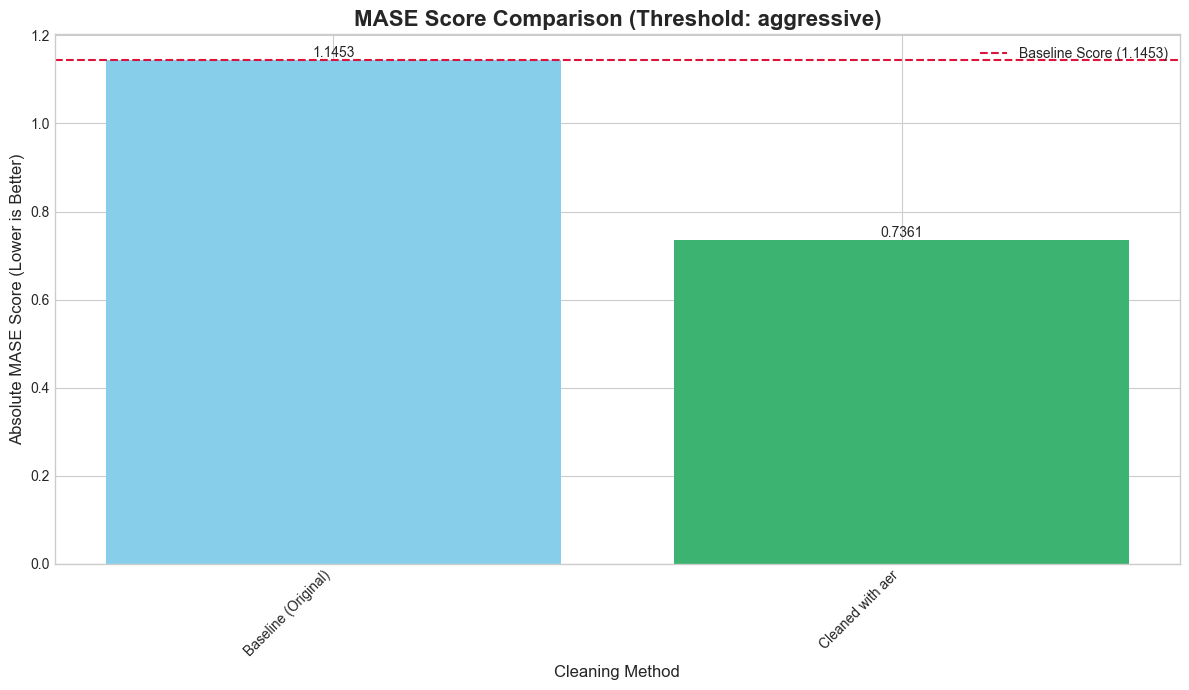

In [ ]:
# =============================================================================
# CELL 7: PLOT THE RESULTS (NEW)
# =============================================================================
# This cell creates a bar chart to visually compare the MASE scores from the
# baseline and the various cleaning methods.

print("\n--- Generating Comparison Plot ---")

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# We need the absolute value of MASE for plotting, as lower is better
plot_data = summary_df.copy()
plot_data['MASE_Score'] = abs(plot_data['MASE_Score'])

# Create the bar plot
colors = ['skyblue' if 'Baseline' in x else 'mediumseagreen' for x in plot_data['Method']]
bars = ax.bar(plot_data['Method'], plot_data['MASE_Score'], color=colors)

# Add title and labels
ax.set_title(f'MASE Score Comparison (Threshold: {SELECTED_THRESHOLD_NAME})', fontsize=16, weight='bold')
ax.set_ylabel('Absolute MASE Score (Lower is Better)', fontsize=12)
ax.set_xlabel('Cleaning Method', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add score labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center') 

# Add a horizontal line for the baseline score for easy comparison
ax.axhline(y=abs(BASELINE_MASE_SCORE), color='crimson', linestyle='--', label=f'Baseline Score ({abs(BASELINE_MASE_SCORE):.4f})')
ax.legend()

plt.tight_layout()

# Save the plot
plot_filename = f"mase_comparison_{SELECTED_THRESHOLD_NAME}.png"
plot_filepath = os.path.join(SESSION_OUTPUT_DIR, plot_filename)
plt.savefig(plot_filepath)
print(f"Plot saved successfully to: {plot_filepath}")

plt.show()

